# EC2 Fire design of concrete structures

This notebook calculates the temperature inside a concrete cross section using Eurocode simplified formulas. It also draws a cross section with temperatures.

In [1]:
import math

x = 0.0
h = 1.0
rfi = 3600

def theta_1(y, h, Rfi):
    dRfi = 720
    k = 3.3e6
    theta1 = 345*math.log10(1.0+7.0*(Rfi-dRfi)/60)*math.exp(-y*math.sqrt(0.9*k/Rfi))
    return theta1

def theta_2(y, h, Rfi):
    return theta_1(y, h, Rfi) + theta_1(h-y, h, Rfi) 

def theta_0(y, h, Rfi):
    return 0.0

def theta_d(y, z, Rfi):
    ac = 0.04 if Rfi <= 3600 else 0.1
    acy = max(ac-y, 0.0)
    acz = max(ac-z, 0.0)
    return (345*math.log10(1.0+8.0*Rfi/60)-theta_1(0, 1, Rfi))*acy*acz/ac/ac

thetaq = 20+theta_1(x, h, rfi)
thetaw = 20+theta_2(0.1, 0.6, rfi)
thetaq, thetaw 

(892.0323158006117, 69.33113385894362)

In [2]:
zside = 2 # 0, 1, 2
yside = 2 # 0, 1, 2

def temp(Rfi, y, z, by, bz, yside=0, zside=1):
    thz = theta_2 if zside == 2 else theta_1 if zside == 1 else theta_0
    thy = theta_2 if yside == 2 else theta_1 if yside == 1 else theta_0

    ac = 0.04 if Rfi <= 3600 else 0.1
    if yside == 0 or zside == 0:
        dtheta = 0.0
    elif yside == 1 and zside == 1:
        # left bottom corner 
        dtheta = theta_d(y, z, Rfi) if (y <= ac and z <= ac) else 0.0
    elif yside == 1 and zside == 2:
        # left bottom and top corners
        if y <= ac:
            if z <= ac:
                dtheta = theta_d(y, z, Rfi) 
            elif z >= bz-ac:
                dtheta = theta_d(y, bz-z, Rfi)
            else:
                dtheta = 0.0
        else:
            dtheta = 0.0
    elif yside == 2 and zside == 1:
        if z <= ac:
            if y <= ac:
                dtheta = theta_d(y, z, Rfi) 
            elif y >= by-ac:
                dtheta = theta_d(by-y, z, Rfi)
            else:
                dtheta = 0.0
        else:
            dtheta = 0.0
    elif yside == 2 and zside == 2:
        if y <= ac:
            if z <= ac:
                dtheta = theta_d(y, z, Rfi) 
            elif z >= bz-ac:
                dtheta = theta_d(y, bz-z, Rfi)
            else:
                dtheta = 0.0
        elif y >= by-ac:
            if z <= ac:
                dtheta = theta_d(by-y, z, Rfi) 
            elif z >= bz-ac:
                dtheta = theta_d(by-y, bz-z, Rfi)
            else:
                dtheta = 0.0
        else:
            dtheta = 0.0
    else:
        dtheta = 0.0   

    tt = thy(y, by, Rfi) + thz(z, bz, Rfi) - thy(y, by, Rfi)*thz(z, bz, Rfi)/theta_1(0, bz, Rfi)           + dtheta
    return tt+20

th = temp(3600, 0.2, 0.0, 0.4, 0.6, yside, zside)
th

892.032344196043

Temperatures can be calculated approximately by a simplified method. The temperature profile in a section can be visualised here for a rectangular cross section.

In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets as widgets

wby = widgets.BoundedFloatText(value=0.3, step=0.01, min=0.05, max=1.0, description='By (m):', disabled=False)
wbz = widgets.BoundedFloatText(value=0.3, step=0.01, min=0.05, max=1.0, description='Bz (m):', disabled=False)
wyside = widgets.BoundedIntText(value=2, step=1, min=0, max=2, description='Sides Y:', disabled=False)
wzside = widgets.BoundedIntText(value=2, step=1, min=0, max=2, description='Sides Z:', disabled=False)
wrfi = widgets.BoundedFloatText(value=30, step=15, min=15, max=240, description='Rfi (m):', disabled=False)
button = widgets.Button(
    description='Draw',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Draw temperature diagram in cross section',
    icon='calculator' # (FontAwesome names without the `fa-` prefix)
)
vbox = widgets.VBox([wby, wbz, wyside, wzside, wrfi])

In [4]:
def calc_dataframe(by, bz, yside, zside, rfi):
    ny = int(by/0.01+1)
    nz = int(bz/0.01+1)
    rfi *= 60

    yy = np.linspace(0.0, by, num=ny)
    zz = np.linspace(0.0, bz, num=nz)
    df = pd.DataFrame(index=zz, columns=yy)

    for i, y in enumerate(yy):
        for j, z in enumerate(zz):
            #print(i,j,y,z)
            df.iloc[j][i] = temp(rfi, y, z, by, bz, yside, zside)
    return df

#@widgets.interact
#def calc_dataframe(by=wby, bz=wbz, yside=wyside, zside=wzside, rfi=wrfi)

In [5]:
vbox

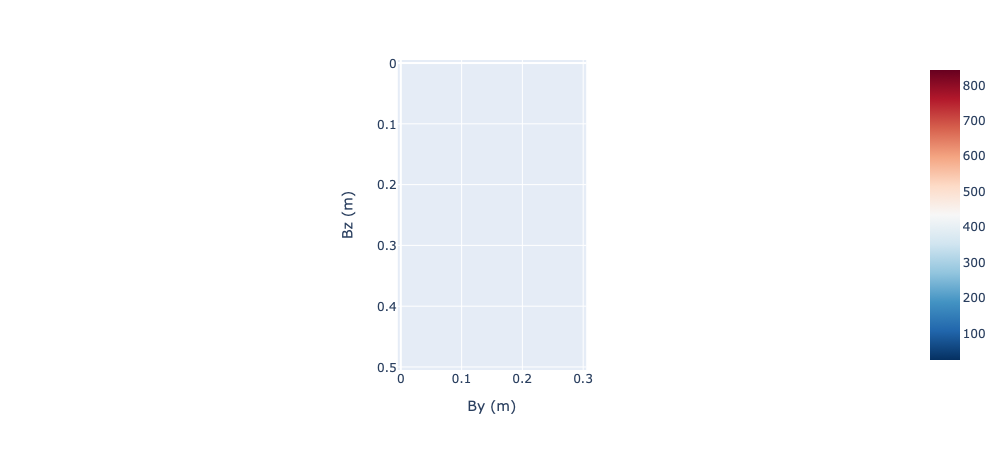

In [7]:
    df = calc_dataframe(wby.value, wbz.value, wyside.value, wzside.value, wrfi.value)
    # 'RdBu_r', 'jet', "Bluered"
    fig = px.imshow(df, labels={'x': 'By (m)', 'y': 'Bz (m)'}, color_continuous_scale='RdBu_r')
    fig.show()